# 08. 차원 축소

In [1]:
# 공통 모듈 임포트
import numpy as np
import os

# 깔금한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)    
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

## 8.1 차원의 저주     

## 8.2 차원 축소를 위한 접근 방법

### 8.2.1 투영

### 8.2.2 매니폴드 학습

## 8.3 PCA

In [2]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

### 8.3.1 분산 보존 

### 8.3.2 주성분

In [3]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

### 8.3.3 d차원으로 투영하기

### 8.3.4 사이킷런 사용하기

In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

### 8.3.5 설명된 분산의 비율

In [5]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

### 8.3.6 적절한 차원 수 선택하기

In [6]:
import gzip

with gzip.open("../datasets/MNIST/train-images-idx3-ubyte.gz", "rb") as f:
    X_train = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 784)
with gzip.open("../datasets/MNIST/train-labels-idx1-ubyte.gz", "rb") as f:
    y_train = np.frombuffer(f.read(), np.uint8, offset=8)
with gzip.open("../datasets/MNIST/t10k-images-idx3-ubyte.gz", "rb") as f:
    X_test = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 784)
with gzip.open("../datasets/MNIST/t10k-labels-idx1-ubyte.gz", "rb") as f:
    y_test = np.frombuffer(f.read(), np.uint8, offset=8)

In [7]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [8]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

### 8.3.7 압축을 위한 PCA

In [9]:
X_reduced.shape

(60000, 154)

In [10]:
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

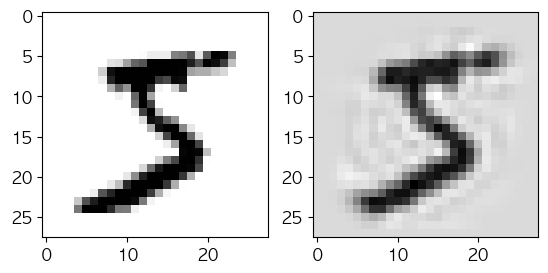

In [11]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(X_train[0].reshape(28, 28), cmap='binary')
axs[1].imshow(X_recovered[0].reshape(28, 28), cmap='binary')

### 8.3.8 랜덤 PCA

### 8.3.9 점진적 PCA

In [12]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)

for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

## 8.4 커널 PCA

In [13]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
y = t > 6.9

In [14]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

### 8.4.1 커널 선택과 하이퍼파라미터 튜닝

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ("kpca", KernelPCA(n_components=2)),
    ("log_reg", LogisticRegression())
])

param_grid = [{
    "kpca__gamma": np.linspace(0.03, 0.05, 10),
    "kpca__kernel": ["rbf", "sigmoid"]
}]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

In [16]:
grid_search.best_params_

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}

In [17]:
rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [18]:
from sklearn.metrics import mean_squared_error
mean_squared_error(X, X_preimage)

41.67710586710211

## 8.5 LLE

In [19]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
X_reduced = lle.fit_transform(X)

## 8.6 다른 차원 축소 기법

## 8.7 연습문제

### 9

In [20]:
with gzip.open("../datasets/MNIST/train-images-idx3-ubyte.gz", "rb") as f:
    X_train = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 784)
with gzip.open("../datasets/MNIST/train-labels-idx1-ubyte.gz", "rb") as f:
    y_train = np.frombuffer(f.read(), np.uint8, offset=8)
with gzip.open("../datasets/MNIST/t10k-images-idx3-ubyte.gz", "rb") as f:
    X_test = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 784)
with gzip.open("../datasets/MNIST/t10k-labels-idx1-ubyte.gz", "rb") as f:
    y_test = np.frombuffer(f.read(), np.uint8, offset=8)

In [23]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [101]:
import time
t0 = time.time()
rnd_clf.fit(X_train, y_train)
t1 = time.time()

In [102]:
t1 - t0

22.3281729221344

In [105]:
from sklearn.metrics import accuracy_score

y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9705

In [106]:
pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

In [108]:
rnd_clf2 = RandomForestClassifier(n_estimators=100, random_state=42)
t0 = time.time()
rnd_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

In [109]:
t1 - t0

71.11165118217468

In [110]:
X_test_reduced = pca.transform(X_test)
y_pred = rnd_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9481

In [111]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(multi_class="multinomial", solver='lbfgs', random_state=42)
t0 = time.time()
log_clf.fit(X_train, y_train)
t1 = time.time()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [112]:
t1 - t0

15.678819179534912

In [113]:
y_pred = log_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9255

In [114]:
log_clf2 = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)
t0 = time.time()
log_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [115]:
t1 - t0

4.9920008182525635

In [118]:
y_pred = log_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9201

### 10

In [119]:
np.random.seed(42)

m = 10000
idx = np.random.permutation(60000)[:m]

X = X_train[idx]
y = y_train[idx]

In [120]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)

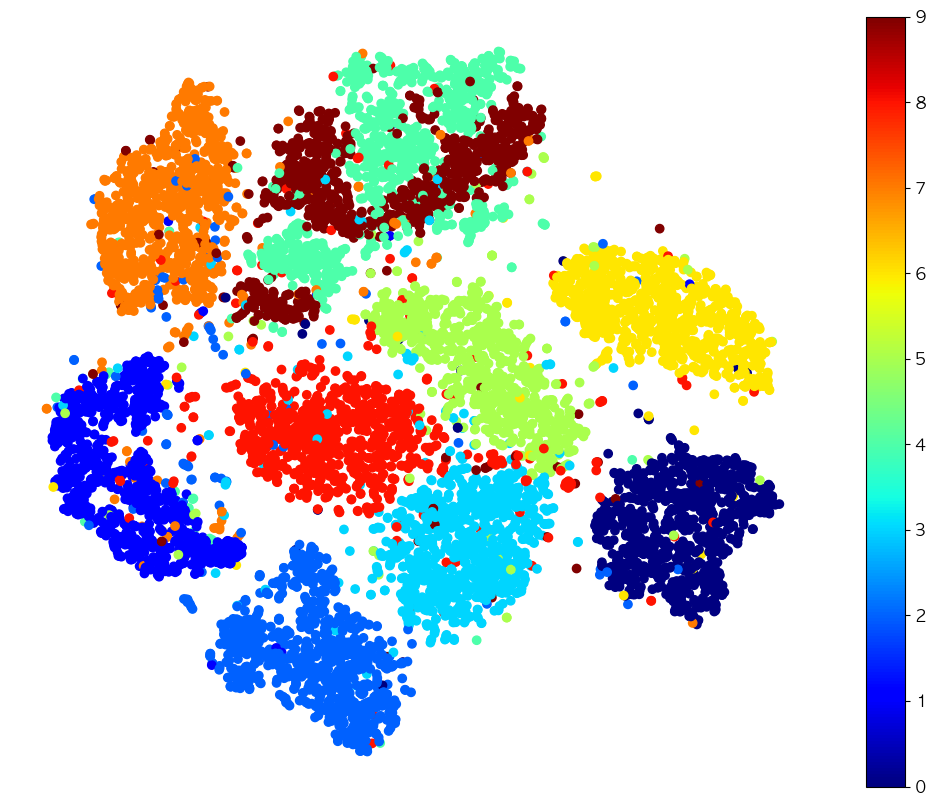

In [121]:
plt.figure(figsize=(13, 10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='jet')
plt.axis('off')
plt.colorbar()
plt.show()

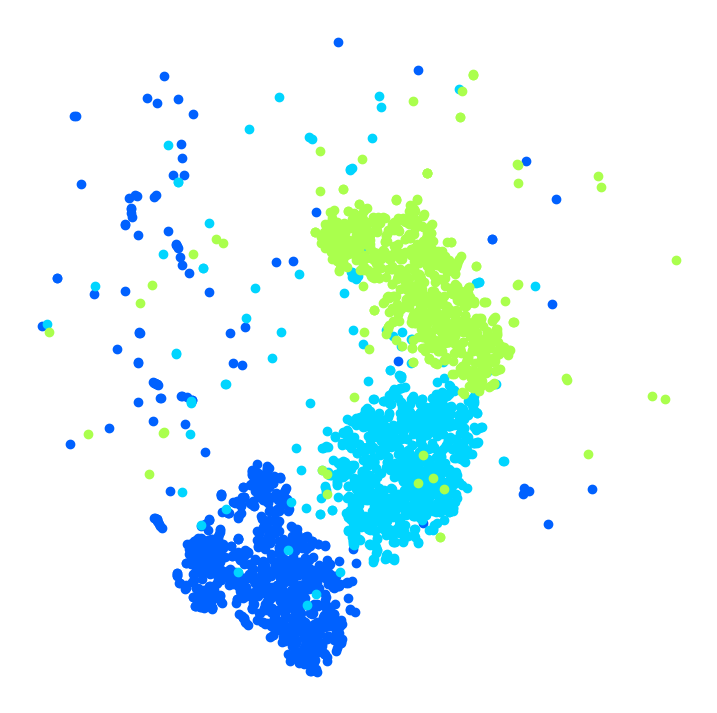

In [122]:
plt.figure(figsize=(9,9))
cmap = mpl.cm.get_cmap('jet')
for digit in (2, 3, 5):
    plt.scatter(X_reduced[y == digit, 0], X_reduced[y == digit, 1], c=[cmap(digit / 9)])
plt.axis('off')
plt.show()

In [123]:
idx = (y == 2) | (y == 3) | (y == 5)
X_subset = X[idx]
y_subset = y[idx]

tsne_subset = TSNE(n_components=2, random_state=42)
X_subset_reduced = tsne_subset.fit_transform(X_subset)

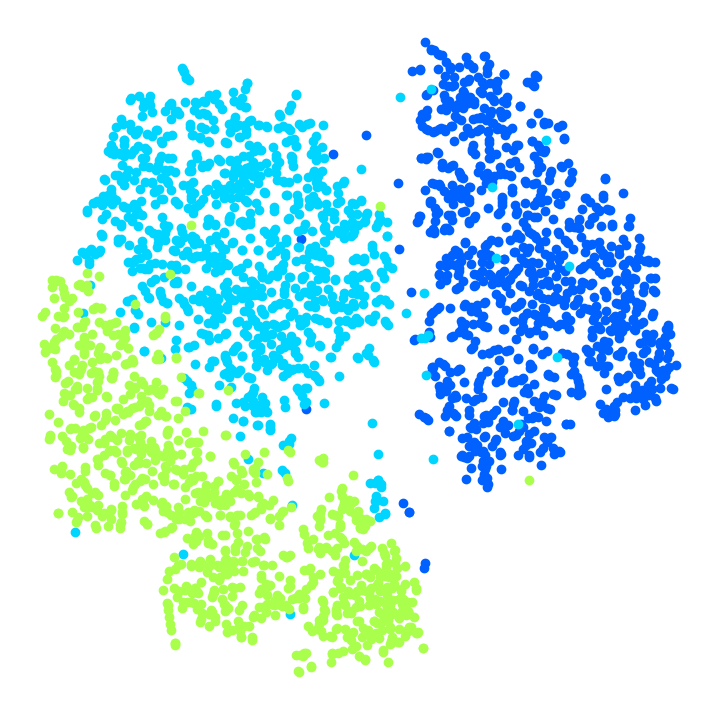

In [124]:
plt.figure(figsize=(9,9))
for digit in (2, 3, 5):
    plt.scatter(X_subset_reduced[y_subset == digit, 0], X_subset_reduced[y_subset == digit, 1], c=[cmap(digit / 9)])
plt.axis('off')
plt.show()